<h2>A Quick Intro to Spark</h2>
<p>Here, I'll walk through some of the basics associated with Data Exploration.  We'll be looking at a data set that is publicly available from <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data">Kaggle</a>, a data science competition website.  Here we'll be doing a little fraud investigation to see if we can build a model to identify fraudulent advertisement clicks.
</p>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

df = spark.read.option("header","true").csv("data/train_sample.csv")
print(df.count())
df.show(10)

100000
+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|
| 68413| 12|     1|  1|    178|2017-11-09 09:00:09|           null|            0|
| 93663|  3|     1| 17|    115|2017-11-09 01:22:13|           null|            0|
| 17059|  1|     1| 17|    135|2017-11-09 01:17:58|           null|            0|
|121505|  9|     1| 25|    442|2017-11-07 10:01:53|           null|            0|
|192967|  2|     2| 22|    364|2017-11-08 09:35:17|           null|            0|
|143636| 

In [3]:
df_att = df[df['is_attributed']==1].cache()
df_att.show(10)
n_att = df_att.count()
print("Number Attributed:", n_att)
df_not = df[df['is_attributed']==0].cache()
df_not.show(10)
n_not = df_not.count()
print("Number Non-attributed", n_not)

+------+---+------+---+-------+-------------------+-------------------+-------------+
|    ip|app|device| os|channel|         click_time|    attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+-------------------+-------------+
|224120| 19|     0| 29|    213|2017-11-08 02:22:13|2017-11-08 02:22:38|            1|
|272894| 10|     1|  7|    113|2017-11-08 06:10:05|2017-11-08 06:10:37|            1|
| 79001| 19|     0|  0|    213|2017-11-07 09:54:22|2017-11-07 11:59:05|            1|
|131029| 19|     0|  0|    343|2017-11-09 10:58:46|2017-11-09 11:52:01|            1|
| 40352| 19|     0|  0|    213|2017-11-07 22:19:03|2017-11-08 01:55:02|            1|
| 48733| 35|     1| 18|    274|2017-11-07 12:25:50|2017-11-07 13:10:30|            1|
|330861| 35|     1| 22|     21|2017-11-08 18:54:44|2017-11-08 22:39:52|            1|
|309576|  5|     1| 32|    113|2017-11-09 08:47:51|2017-11-09 08:47:55|            1|
|220571| 71|     1| 25|      3|2017-11-08 04:35:21|201

In [3]:
print("Unique IPs:", df_not.select("ip").distinct().count())
print("Unique Apps:", df_not.select("app").distinct().count())
print("Unique Device Codes:", df_not.select("device").distinct().count())
print("Unique OS:", df_not.select("os").distinct().count())
print("Unique Channel:", df_not.select("channel").distinct().count())

Unique IPs: 34707
Unique Apps: 155
Unique Device Codes: 91
Unique OS: 129
Unique Channel: 159


In [4]:
print("Unique IPs:", df_att.select("ip").distinct().count())
print("Unique Apps:", df_att.select("app").distinct().count())
print("Unique Device Codes:", df_att.select("device").distinct().count())
print("Unique OS:", df_att.select("os").distinct().count())
print("Unique Channel:", df_att.select("channel").distinct().count())

Unique IPs: 223
Unique Apps: 37
Unique Device Codes: 25
Unique OS: 39
Unique Channel: 40


In [4]:
app_att = df_att.select(df['app'].cast("int")).rdd\
                .map(lambda x: (x.app, 1))\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_att))\
                .filter(lambda x: x[1]>.01)\
                .sortBy(lambda x: x[1], ascending=False).collectAsMap()
  
l_app_att = [x[0] for x in app_att.items()]



app_not = df_not.select(df['app'].cast("int")).rdd\
                .map(lambda x: (x.app, 1))\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_not))\
                .sortBy(lambda x: x[1], ascending=False).take(10)

app_not_in_l = df_not.select(df['app'].cast("int")).rdd\
                    .map(lambda x: (x.app, 1))\
                    .filter(lambda x: x[0] in l_app_att)\
                    .reduceByKey(lambda x, y: x+y)\
                    .map(lambda x: (x[0], x[1]/n_not))\
                    .collect()

diffs = [(x[0], app_att[x[0]] - x[1]) for x in app_not_in_l]
for app in sorted(diffs, key=lambda x: x[1], reverse=True):
    print("Difference in percentages (attributed - not) for app {}:".format(app[0]), app[1])


Difference in percentages (attributed - not) for app 19: 0.30428076138119875
Difference in percentages (attributed - not) for app 35: 0.11872223074131583
Difference in percentages (attributed - not) for app 29: 0.09352860950304327
Difference in percentages (attributed - not) for app 10: 0.07558673607591436
Difference in percentages (attributed - not) for app 5: 0.059930050024127456
Difference in percentages (attributed - not) for app 45: 0.04820758098857976
Difference in percentages (attributed - not) for app 72: 0.02633149054521164
Difference in percentages (attributed - not) for app 39: 0.013085563259435924
Difference in percentages (attributed - not) for app 83: 0.01303544950120474
Difference in percentages (attributed - not) for app 8: -0.002424357918024575
Difference in percentages (attributed - not) for app 9: -0.05480211004089414
Difference in percentages (attributed - not) for app 18: -0.06126263446216744
Difference in percentages (attributed - not) for app 3: -0.16554464096053

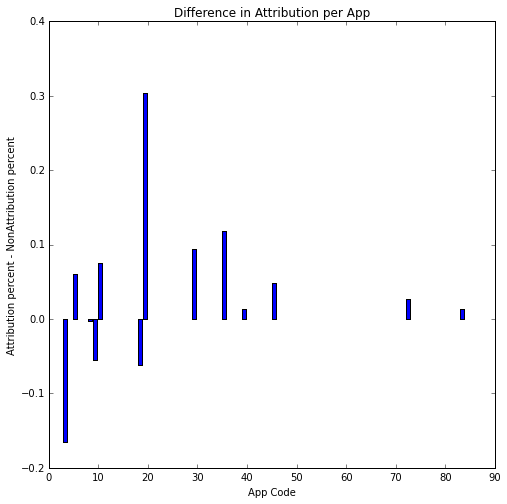

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar([x[0] for x in diffs], [x[1] for x in diffs])
ax.set_title("Difference in Attribution per App")
ax.set_ylabel("Attribution percent - NonAttribution percent")
_ = ax.set_xlabel("App Code")

In [5]:
from pyspark.sql.functions import udf
from datetime import datetime
from pyspark.sql.types import TimestampType, BooleanType, NumericType, IntegerType

def is_app_num(col_num, num):
    return col_num==str(num)

make_app_n = udf(lambda app_col: is_app_num(app_col, '19') , BooleanType())
df = df.withColumn("is_app_19", make_app_n(df['app']))


make_app_n = udf(lambda app_col: is_app_num(app_col, '35') , BooleanType())
df = df.withColumn("is_app_35", make_app_n(df['app']))


make_app_n = udf(lambda app_col: is_app_num(app_col, '29') , BooleanType())
df = df.withColumn("is_app_29", make_app_n(df['app']))


make_app_n = udf(lambda app_col: is_app_num(app_col, '10') , BooleanType())
df = df.withColumn("is_app_10", make_app_n(df['app']))


make_dt = udf(lambda date_string: datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S"), \
              TimestampType())
df = df.withColumn("dt_click", make_dt(df['click_time']))


df.show(5)


+------+---+------+---+-------+-------------------+---------------+-------------+---------+---------+---------+---------+-------------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|is_app_19|is_app_35|is_app_29|is_app_10|           dt_click|
+------+---+------+---+-------+-------------------+---------------+-------------+---------+---------+---------+---------+-------------------+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|    false|    false|    false|    false|2017-11-07 09:30:38|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|    false|    false|    false|    false|2017-11-07 13:40:27|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|    false|    false|    false|    false|2017-11-07 18:05:24|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|    false|    false|    false|    false|2017-11-07 04:58:08|
| 6841

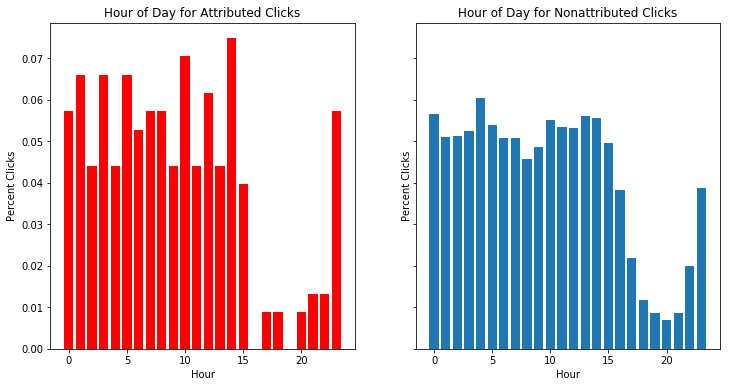

In [6]:
df_att = df[df['is_attributed']==1]
hr_att = df_att.select('dt_click').rdd.flatMap(lambda x: x)\
                .map(lambda x: (x.hour, 1)).reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_att)).sortBy(lambda x: x[0]).collect()
    
df_not = df[df['is_attributed']==0]
hr_not = df_not.select('dt_click').rdd.flatMap(lambda x: x)\
                .map(lambda x: (x.hour, 1)).reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_not)).sortBy(lambda x: x[0]).collect()
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar([x[0] for x in hr_att], [x[1] for x in hr_att], color='r')
ax[0].set_title("Hour of Day for Attributed Clicks")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Percent Clicks")
ax[1].bar([x[0] for x in hr_not], [x[1] for x in hr_not])
ax[1].set_title("Hour of Day for Nonattributed Clicks")
ax[1].set_xlabel("Hour")
_  = ax[1].set_ylabel("Percent Clicks")

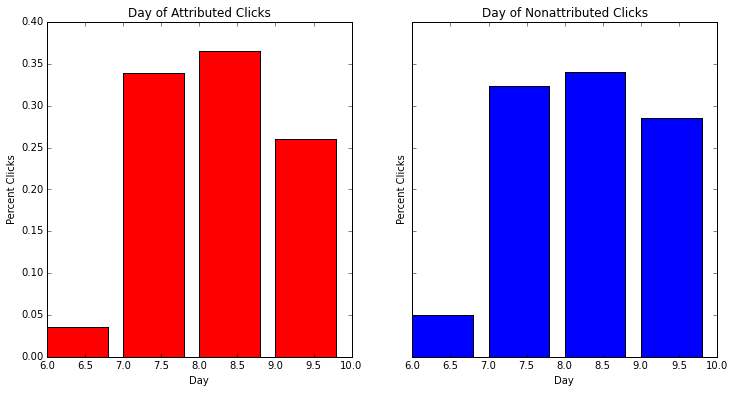

In [9]:
df_att = df[df['is_attributed']==1]
hr_att = df_att.select('dt_click').rdd.flatMap(lambda x: x)\
                .map(lambda x: (x.day, 1)).reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_att)).sortBy(lambda x: x[0]).collect()
    
df_not = df[df['is_attributed']==0]
hr_not = df_not.select('dt_click').rdd.flatMap(lambda x: x)\
                .map(lambda x: (x.day, 1)).reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0], x[1]/n_not)).sortBy(lambda x: x[0]).collect()
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar([x[0] for x in hr_att], [x[1] for x in hr_att], color='r')
ax[0].set_title("Day of Attributed Clicks")
ax[0].set_xlabel("Day")
ax[0].set_ylabel("Percent Clicks")
ax[1].bar([x[0] for x in hr_not], [x[1] for x in hr_not])
ax[1].set_title("Day of Nonattributed Clicks")
ax[1].set_xlabel("Day")
_ = ax[1].set_ylabel("Percent Clicks")

In [7]:
ip_att = df_att.select('ip').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1)).reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[1]>1).sortBy(lambda x: x[1], ascending=False).collect()
    
print(ip_att)


ip_not = df_not.select('ip').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1)).reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[1]>1).sortBy(lambda x: x[1], ascending=False).take(20)
    
print(ip_not)

[(5348, 3), (5314, 3)]
[(5348, 666), (5314, 613), (73487, 439), (73516, 399), (53454, 280), (114276, 219), (26995, 218), (95766, 205), (17149, 186), (100275, 173), (105475, 167), (105560, 149), (111025, 136), (43793, 135), (86767, 134), (137052, 128), (5178, 117), (49602, 116), (48282, 112), (48170, 112)]


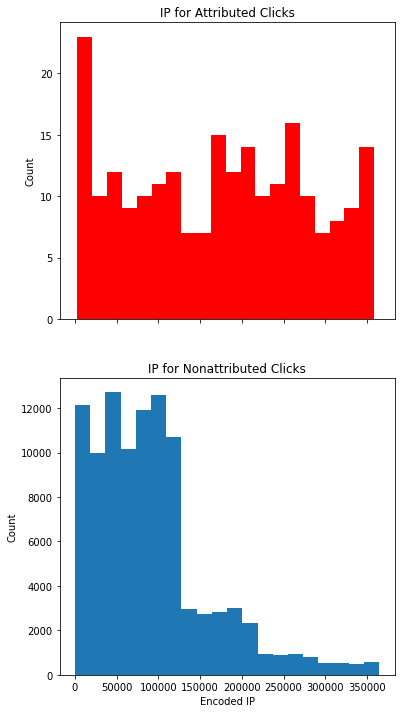

In [8]:
ip_att = df_att.select('ip').rdd.flatMap(lambda x: x).map(lambda x: int(x)).collect()
ip_not = df_not.select('ip').rdd.flatMap(lambda x: x).map(lambda x: int(x)).collect()

fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True)
ax[0].hist(ip_att, color='r', bins=20)
ax[0].set_title("IP for Attributed Clicks")
ax[0].set_ylabel("Count")
ax[1].hist(ip_not, bins=20)
ax[1].set_title("IP for Nonattributed Clicks")
ax[1].set_xlabel("Encoded IP")
_ = ax[1].set_ylabel("Count")

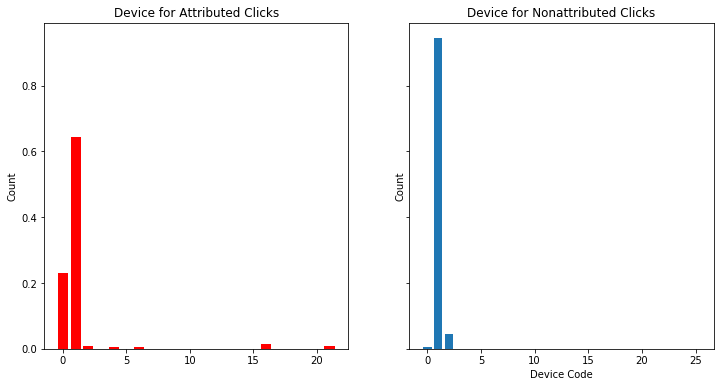

In [9]:
dev_att = df_att.select('device').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1/n_att))\
                .reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[0] < 30)\
                .collectAsMap()
            
dev_not = df_not.select('device').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1/n_not))\
                .reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[0] < 30)\
                .collectAsMap()

dev_att = sorted([x for x in dev_att.items()], key=lambda x:x[0])
dev_not = sorted([x for x in dev_not.items()], key=lambda x:x[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar([x[0] for x in dev_att], [x[1] for x in dev_att], color='r')
ax[0].set_title("Device for Attributed Clicks")
ax[0].set_ylabel("Count")
ax[1].bar([x[0] for x in dev_not], [x[1] for x in dev_not])
ax[1].set_title("Device for Nonattributed Clicks")
ax[1].set_xlabel("Device Code")
_ = ax[1].set_ylabel("Count")


In [13]:
os_att = df_att.select('os').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1))\
                .reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[1]>4)\
                .sortBy(lambda x: x[1], ascending=False)\
                .collectAsMap()

os_not = df_not.select('os').rdd.flatMap(lambda x: x)\
                .map(lambda x: (int(x), 1))\
                .reduceByKey(lambda x, y: x+y)\
                .filter(lambda x: x[0] in os_att)\
                .sortBy(lambda x: x[1], ascending=False)\
                .collect()                

os_att = [x for x in sorted(os_att.items(), key=lambda x: x[1], reverse=True)]
print(os_att, "\n")
print(os_not)



[(19, 41), (0, 26), (24, 26), (13, 25), (29, 11), (21, 8), (17, 6), (22, 6), (27, 6), (7, 5), (25, 5)] 

[(19, 23829), (13, 21198), (17, 5226), (22, 4033), (25, 2243), (27, 1002), (0, 173), (24, 168), (7, 108), (21, 52), (29, 45)]


In [14]:
# Create a labeled point with a positive label and a dense feature vector.
def create_point(row):
    return LabeledPoint(row.is_attributed, \
                        [row.is_app_19, row.is_app_35, \
                         row.is_app_29, row.is_app_10,\
                        int(row.device), int(row.ip)])


In [15]:
data = df.rdd.map(lambda x: create_point(x))
data.cache()
data.count()

100000

In [16]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(testData.filter(lambda x: x.label==1).count())
print(trainingData.filter(lambda x: x.label==1).count())

69
158


In [17]:
#model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
#                                     numTrees=5, featureSubsetStrategy="auto",
#                                     impurity='gini', maxDepth=6, maxBins=32)

model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    numTrees=5, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=6, maxBins=32)

In [18]:
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)


At threshold {} 1.0
	Accuracy: 0.9977099236641221
	Precision:  0
	Recall:  0.0
At threshold {} 0.75
	Accuracy: 0.9977099236641221
	Precision:  0
	Recall:  0.0
At threshold {} 0.5
	Accuracy: 0.9977763026883505
	Precision:  0.625
	Recall:  0.07246376811594203
At threshold {} 0.3
	Accuracy: 0.9979090607368072
	Precision:  0.6875
	Recall:  0.15942028985507245
At threshold {} 0.2
	Accuracy: 0.9977099236641221
	Precision:  0.5
	Recall:  0.34782608695652173
At threshold {} 0.1
	Accuracy: 0.9941918353800199
	Precision:  0.2087912087912088
	Recall:  0.5507246376811594
At threshold {} 0.05
	Accuracy: 0.9929970129439097
	Precision:  0.18018018018018017
	Recall:  0.5797101449275363
At threshold {} 0.01
	Accuracy: 0.9856621307666777
	Precision:  0.10629067245119306
	Recall:  0.7101449275362319
At threshold {} 0.005
	Accuracy: 0.9236973116495186
	Precision:  0.02512776831345826
	Recall:  0.855072463768116
At threshold {} 0.001
	Accuracy: 0.8680384998340525
	Precision:  0.015621125712868828
	Recall: 

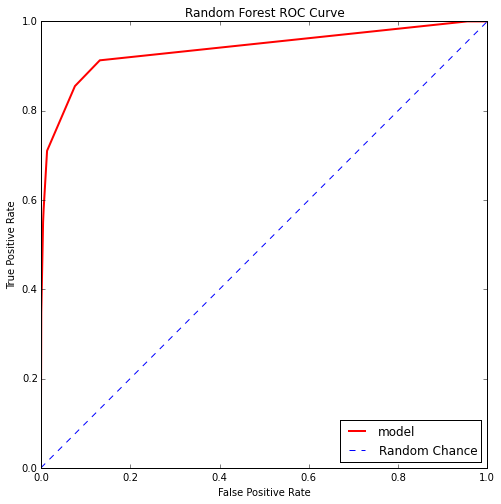

In [24]:
cond_pos = [x for x in labelsAndPredictions.collect() if x[0]==1]
cond_neg = [x for x in labelsAndPredictions.collect() if x[0]==0]
n_pos = len(cond_pos)
n_neg = len(cond_neg)
thresholds = [1., .75, .5, .3, .2, .1, .05, .01, .005, .001, .0008, .0005, 0]
points = []
for thresh in thresholds:
    tpr = float(len([x for x in cond_pos if x[1]>thresh]))/n_pos
    fpr = float(len([x for x in cond_neg if x[1]>thresh]))/n_neg
    acc = (tpr*n_pos +(1-fpr)*n_neg)/(n_pos+n_neg)
    pre = tpr*n_pos/(tpr*n_pos + fpr*n_neg) if tpr*n_pos + fpr*n_neg>0 else 0
    rec = tpr*n_pos/n_pos
    print("At threshold {}", thresh)
    print("\tAccuracy:", acc)
    print("\tPrecision: ", pre)
    print("\tRecall: ", rec)
    points.append((fpr, tpr))
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([x[0] for x in points], [x[1] for x in points], color='r', linewidth=2.0, label="model")
ax.plot([0., 1.], [0., 1.], linestyle="--", label="Random Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Random Forest ROC Curve")
_ = ax.legend(loc='lower right')